# microsim guide

This guide walks through some of the basic concepts of microsim, with examples

## Creating a sample

The simulation begins with some sort of sample or "ground truth".  This is
essentially a spatial distribution of signal-emitting objects.  `microsim`
provides a few built-in sample distributions, but you can also create your own.

The distribution is represented as a count of fluorophores in a 3-dimensional
space.  That space is referred to as the *truth space*.  So, a very basic sample
example, drawing some randomly oriented lines into a 64x256x256 space, with a
ground truth voxel size of 10nm x 10nm x 10nm, might look like this:

In [1]:
%load_ext autoreload
%autoreload 2

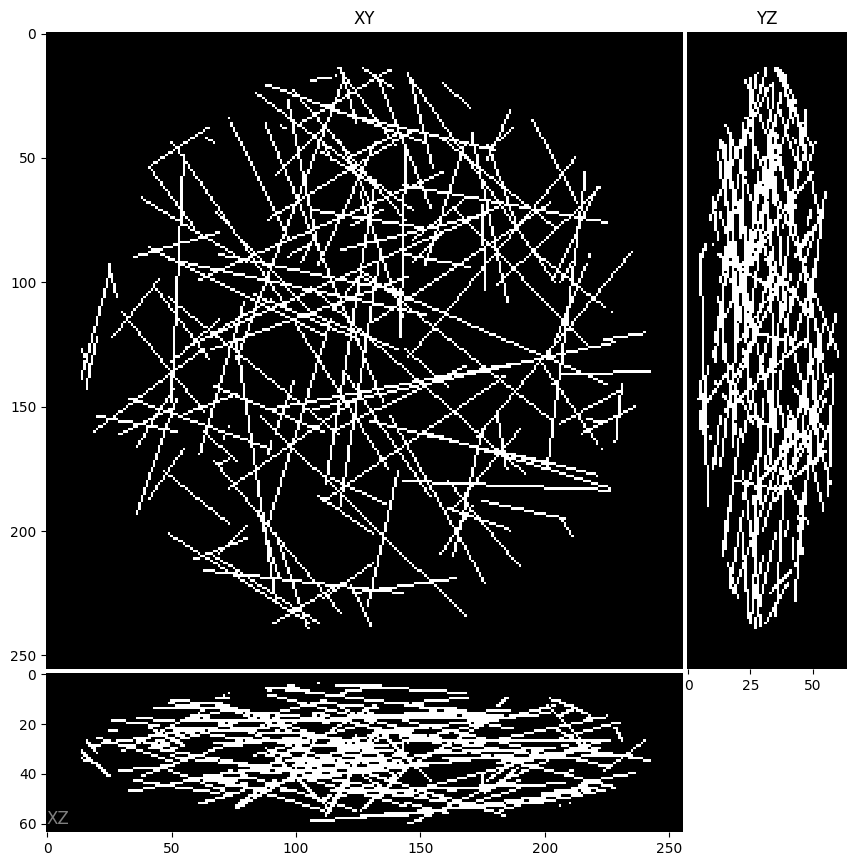

In [2]:
from microsim import schema as ms
from microsim.util import ortho_plot

sim = ms.Simulation(
    truth_space=ms.ShapeScaleSpace(shape=(64, 256, 256), scale=0.01),
    sample=[ms.MatsLines()],
)

ortho_plot(sim.ground_truth(), mip=True)

## Biologically realistic ground truth from Janelia CellMap

We can also create more biologically realistic ground truth.  For example,
microsim provides a wrapper around the Janelia
[OpenOrganelle](https://www.openorganelle.org) dataset, which is a rich dataset
of FIB-SEM images of cells, together with annotations of various organelles.
Let's simulate endoplasmic reticulum (ER) and mitochondria (mito):

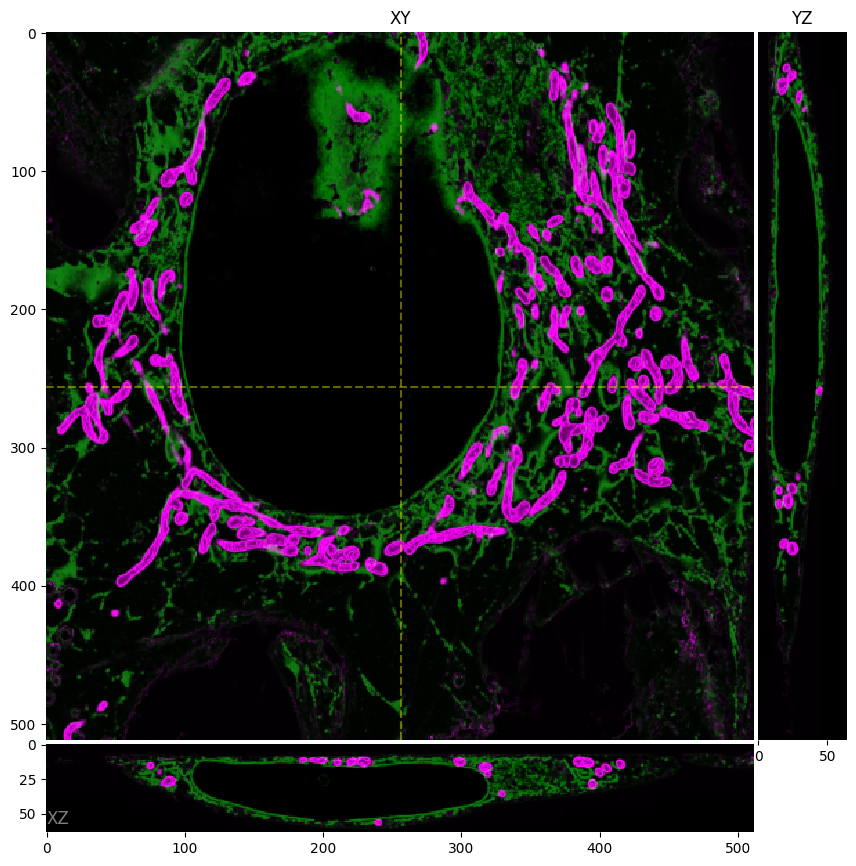

In [3]:
from microsim import schema as ms

sim = ms.Simulation(
    truth_space=ms.ShapeScaleSpace(
        shape=(64, 512, 512),
        scale=(0.064, 0.064, 0.064),
    ),
    # dataset & label names from https://openorganelle.janelia.org/datasets
    sample=[
        ms.CosemLabel(dataset="jrc_hela-3", label="er-mem_pred"),
        ms.CosemLabel(dataset="jrc_hela-3", label="mito-mem_pred"),
    ],
)

ortho_plot(sim.ground_truth())

(or, plotted as maximum intensity projection):

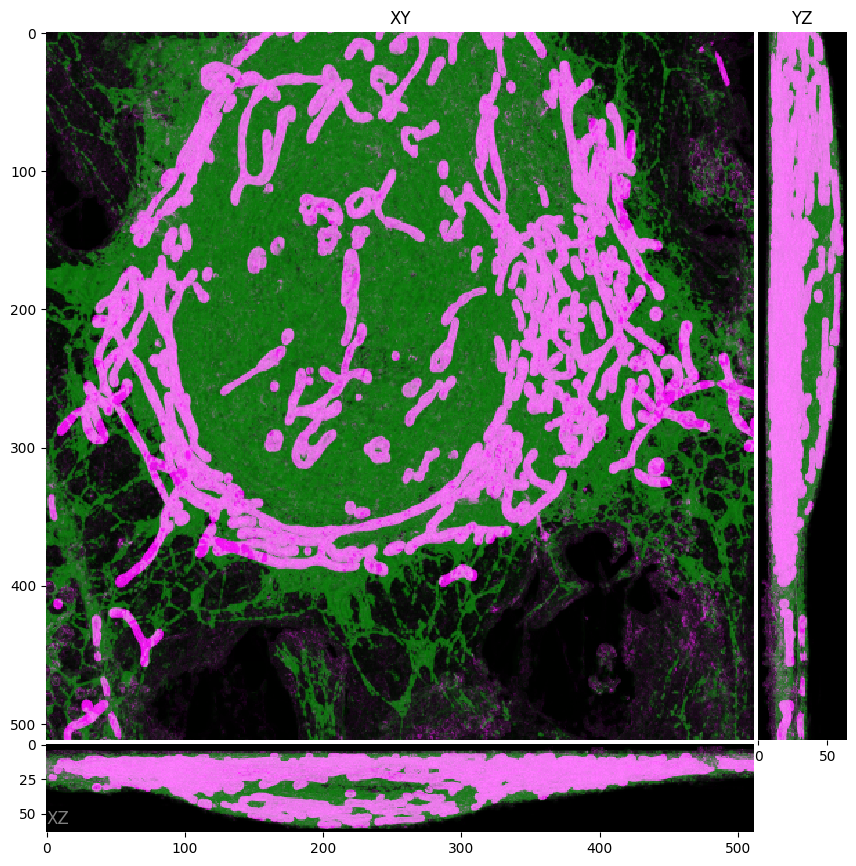

In [4]:
ortho_plot(sim.ground_truth(), mip=True)

Without any additional config, we can simulate an image as acquired by a
widefield microscope:

INFO:root:Rendering channel FITC -----------------
INFO:root:>> fluor mockFluorophore
INFO:root:>>>> @ 525.2525940250172 nm
INFO:root:Using cached PSF: /Users/talley/Library/Caches/microsim/psf/_1-515_1-515_170-0_170-0_1-515_1-515_1-0_1-4_1-47_150-0/64_57_0-064_0-064_0-5252525940250172.npy
INFO:root:NumpyAPI.fftconvolve a.shape=(64, 512, 512) b.shape=(65, 58, 58) a.dtype=dtype('float64')
INFO:root:>> fluor mockFluorophore
INFO:root:>>>> @ 525.2525940250172 nm
INFO:root:NumpyAPI.fftconvolve a.shape=(64, 512, 512) b.shape=(65, 58, 58) a.dtype=dtype('float64')


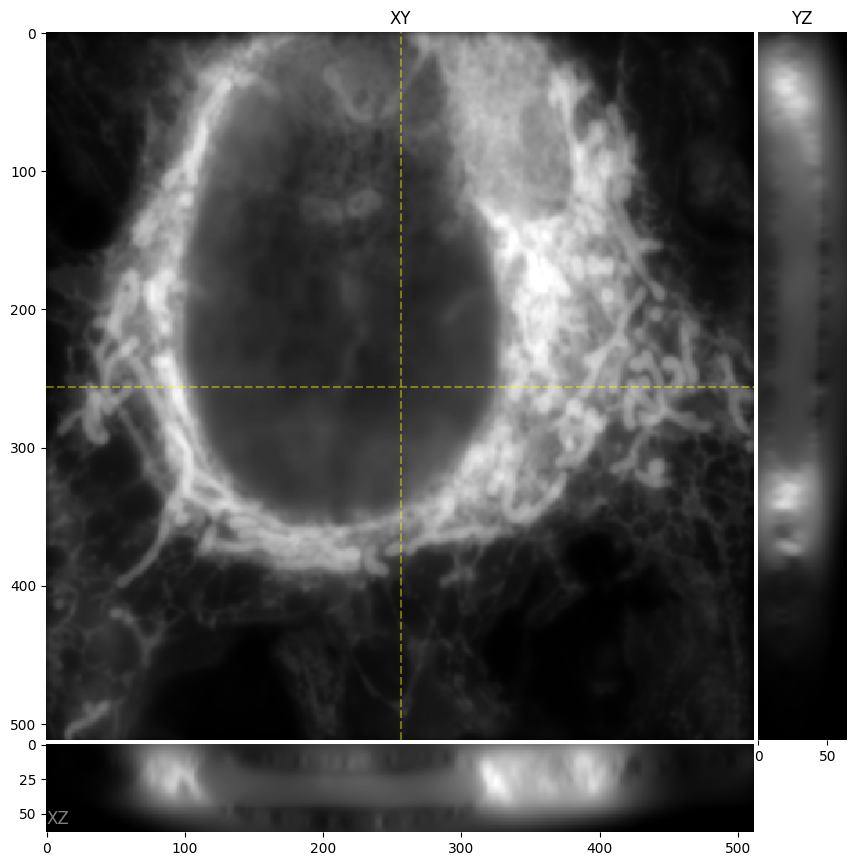

In [5]:
result = sim.digital_image()

ortho_plot(result)

Interesting ... looks more or less like a widefield image of a cell.
But there's something wrong: the organelles are in the same channel!
Let's add the concept of fluorophores and optical configurations.

## Fluorophores, Spectra, and Optical Configurations

Here we'll turn the three `CosemLabel` objects into `FluorophoreDistribution`
objects, each with a specified `fluorophore` (the information for each fluorophore is
pulled from [FPbase](https://fpbase.org).  We'll also specify the `channels`
in the simulation, which is a list of `OpticalConfiguration` objects.  These objects
describe the optical configuration of the microscope, including the excitation and
emission spectra of the light sources and detectors (The
`microsim.schema.optical_config.lib` module provides a library of common optical
configurations)

In [6]:
from microsim import schema as ms

sim = ms.Simulation(
    truth_space=ms.ShapeScaleSpace(
        shape=(64, 512, 512),
        scale=(0.064, 0.064, 0.064),
    ),
    # dataset & label names from https://openorganelle.janelia.org/datasets
    sample=[
        ms.FluorophoreDistribution(
            distribution=ms.CosemLabel(dataset="jrc_hela-3", label="er-mem_pred"),
            fluorophore="EGFP",
        ),
        ms.FluorophoreDistribution(
            distribution=ms.CosemLabel(dataset="jrc_hela-3", label="mito-mem_pred"),
            fluorophore="mCherry",
        ),
    ],
    channels=[
        ms.OpticalConfig.from_fpbase(
            microscope_id="wKqWbg", config_name="Widefield Green"
        ),
        ms.OpticalConfig.from_fpbase(
            microscope_id="wKqWbg", config_name="Widefield Red"
        ),
    ],
)

Let's first discuss how the fluorophores are excited and collected by our optical
configurations. The number of photons emitted by a fluorophore and collected by a
detector in any given channel is determined by multiple things, including:

1. How well the absorption spectrum of the fluorophore overlaps with the excitation
   spectrum of the light source
2. How well the emission spectrum of the fluorophore overlaps with the spectra of
   the filters in the emission path and the detector.

### Fluorophore Absorption Spectrum

We can visualize the absorption spectra of the fluorophores in our
sample, which represents how well each of the fluorophores absorbs light at a specific wavelength:

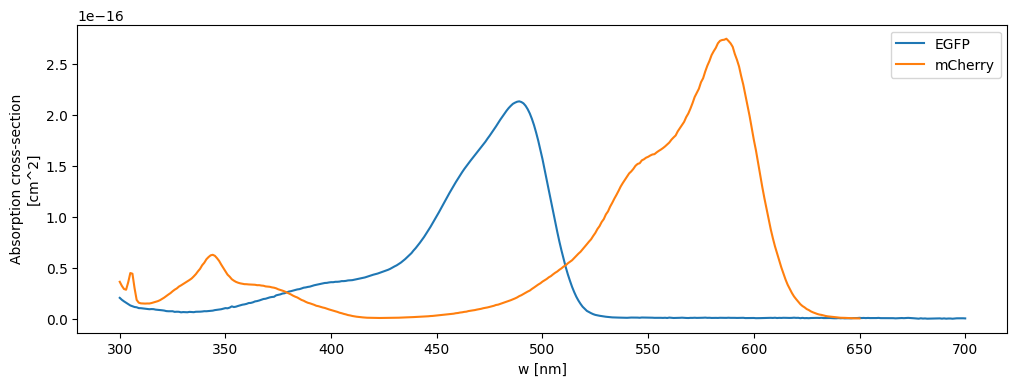

In [7]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 4))
for lbl in sim.sample.labels:
    fluor = lbl.fluorophore
    fluor.absorption_cross_section.plot.line(label=fluor.name)

plt.legend()
plt.show()

The excitation spectra have been scaled here by the extinction coefficient of the
fluorophore and converted to
[absorption cross-section](https://en.wikipedia.org/wiki/Absorption_cross_section)
($\sigma$) using the formula:

$$
  \sigma = \log(10) \times 10^3 \times \frac{E(\lambda)}{N_A}
$$

Where $E(\lambda)$ is the extinction coefficient in $M^{-1} cm^{-1}$, and $N_A$ is Avogadro's number.

### Illumination flux

The filters and light sources in each of the optical configurations determines its excitation profile and power.  Here, we plot the individual excitation profiles of each of the filters in each channel, as well as the total combined **illumination flux** density ($photons / cm^2 / sec$) for each channel:

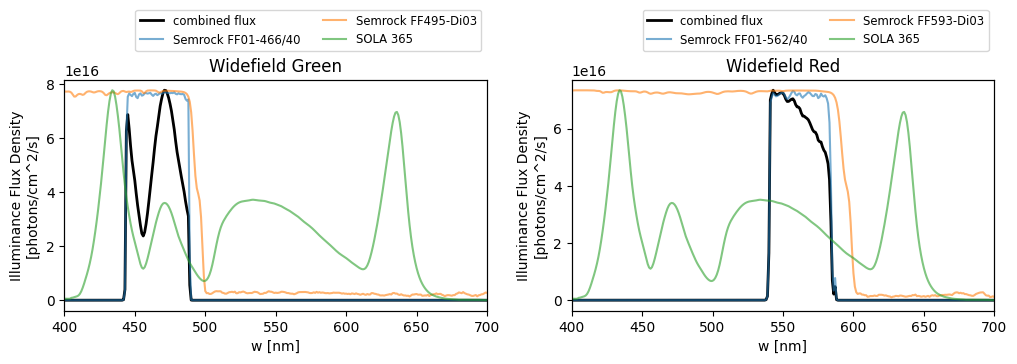

In [8]:
fig, axes = plt.subplots(1, len(sim.channels), figsize=(12, 3))
for _ch_idx, oc in enumerate(sim.channels):
    oc.plot_excitation(ax=axes[_ch_idx])

### Absorption Rate

The product of the absorption cross section and the excitation spectrum gives us the wavelength-dependent **absorption rate** 
(in photons/sec) for each channel-fluorophore pair.

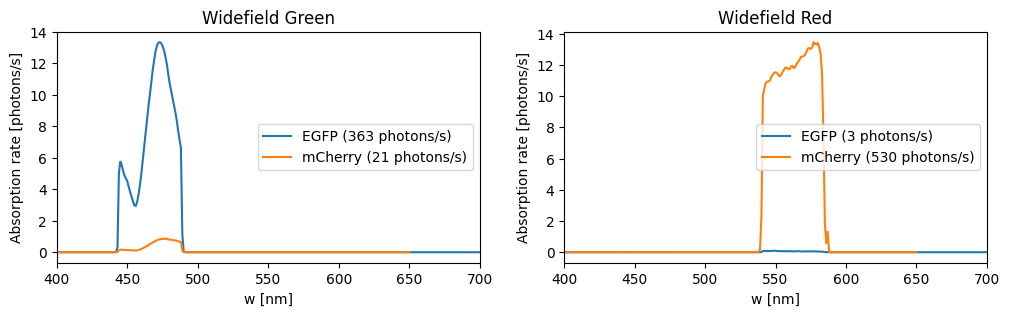

In [39]:
fig, axes = plt.subplots(1, len(sim.channels), figsize=(12, 3))
for _ch_idx, oc in enumerate(sim.channels):
    for lbl in sim.sample.labels:
        fluor = lbl.fluorophore
        abs_rate = oc.absorption_rate(fluor)
        label = f'{fluor.name} ({abs_rate.sum():.0f} photons/s)'
        abs_rate.plot(ax=axes[_ch_idx], label=label)
    axes[_ch_idx].set_xlim(400, 700)
    axes[_ch_idx].legend(loc='center right')
    axes[_ch_idx].set_title(oc.name)

### Emission Rate

We convert absorption rate to emission rate by normalizing the area under the emission
spectrum of the fluorophore to the total number of photons absorbed by the fluorophore,
multiplied by the **quantum yield** of the fluorophore.  This gives us the number of photons
emitted by each fluorophore, when illuminated by each channel, at each wavelength:

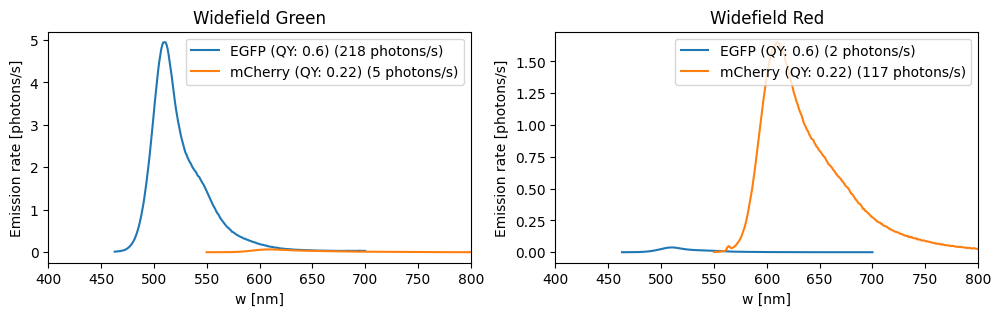

In [51]:
fig, axes = plt.subplots(1, len(sim.channels), figsize=(12, 3))
for _ch_idx, oc in enumerate(sim.channels):
    for lbl in sim.sample.labels:
        fluor = lbl.fluorophore
        em_rate = oc.total_emission_rate(fluor)
        label = (
            f"{fluor.name} (QY: {fluor.quantum_yield}) "
            f"({em_rate.sum():.0f} photons/s)"
        )
        em_rate.plot(ax=axes[_ch_idx], label=label)
    axes[_ch_idx].set_xlim(400, 800)
    axes[_ch_idx].legend()
    axes[_ch_idx].set_title(oc.name)

As expected, EGFP is emitting more photons when imaged in the "Widefield Green"
channel, and mCherry is emitting more photons when imaged in the "Widefield Red" channel.

### Collection Efficiency

The photons then travel through the emission filters and be collected by the detector.
The product of the emission rate and the combined transmission percentage of all of the
filters in the emission path (and the QE of the detector if specified) gives us the
number of photons detected by the detector for each fluorophore, in each channel:

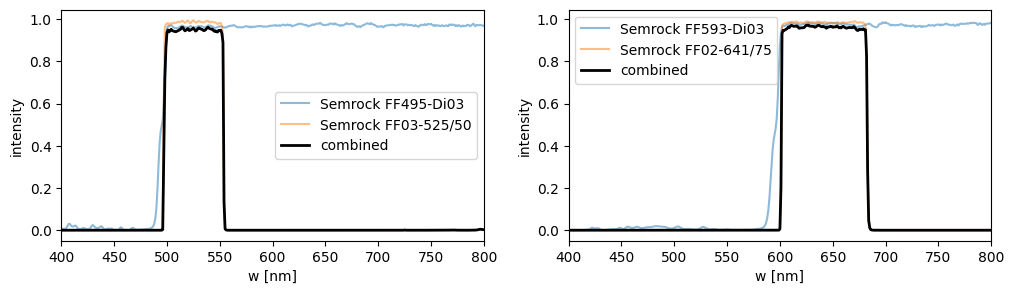

In [64]:
fig, axes = plt.subplots(1, len(sim.channels), figsize=(12, 3))
for _ch_idx, oc in enumerate(sim.channels):
    oc.plot_emission(ax=axes[_ch_idx])

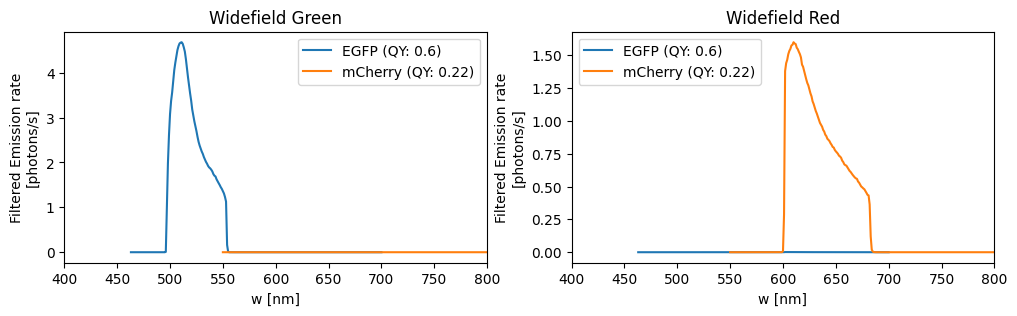

In [53]:
fig, axes = plt.subplots(1, len(sim.channels), figsize=(12, 3))
for _ch_idx, oc in enumerate(sim.channels):
    for lbl in sim.sample.labels:
        fluor = lbl.fluorophore
        em_rate = oc.filtered_emission_rate(fluor)
        em_rate.plot(ax=axes[_ch_idx], label=f"{fluor.name} (QY: {fluor.quantum_yield})")
    axes[_ch_idx].set_xlim(400, 800)
    axes[_ch_idx].legend()
    axes[_ch_idx].set_title(oc.name)